In [108]:
import os
import sys
sys.path.append('../')
import numpy as np
import scipy.io as scio
import h5py
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import numba
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tempfile import gettempdir
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC
from kwave.utils import *
from kwave.ktransducer import *
from kwave.kmedium import kWaveMedium

%matplotlib inline

### Load in brain data

In [109]:
data_path = '/mnt/WD6TB/tianaoli/brains/'
data = scio.loadmat(os.path.join(data_path, '0.11.mat'))
brain3d = data['recondata_cut_mc_bgb']
print(brain3d.shape)
print(brain3d.min(), brain3d.max())

(256, 256, 256)
-1069.4133 3551.3313


### Visualization

In [119]:
x_sec = 100
y_sec = 100
z_sec = 100

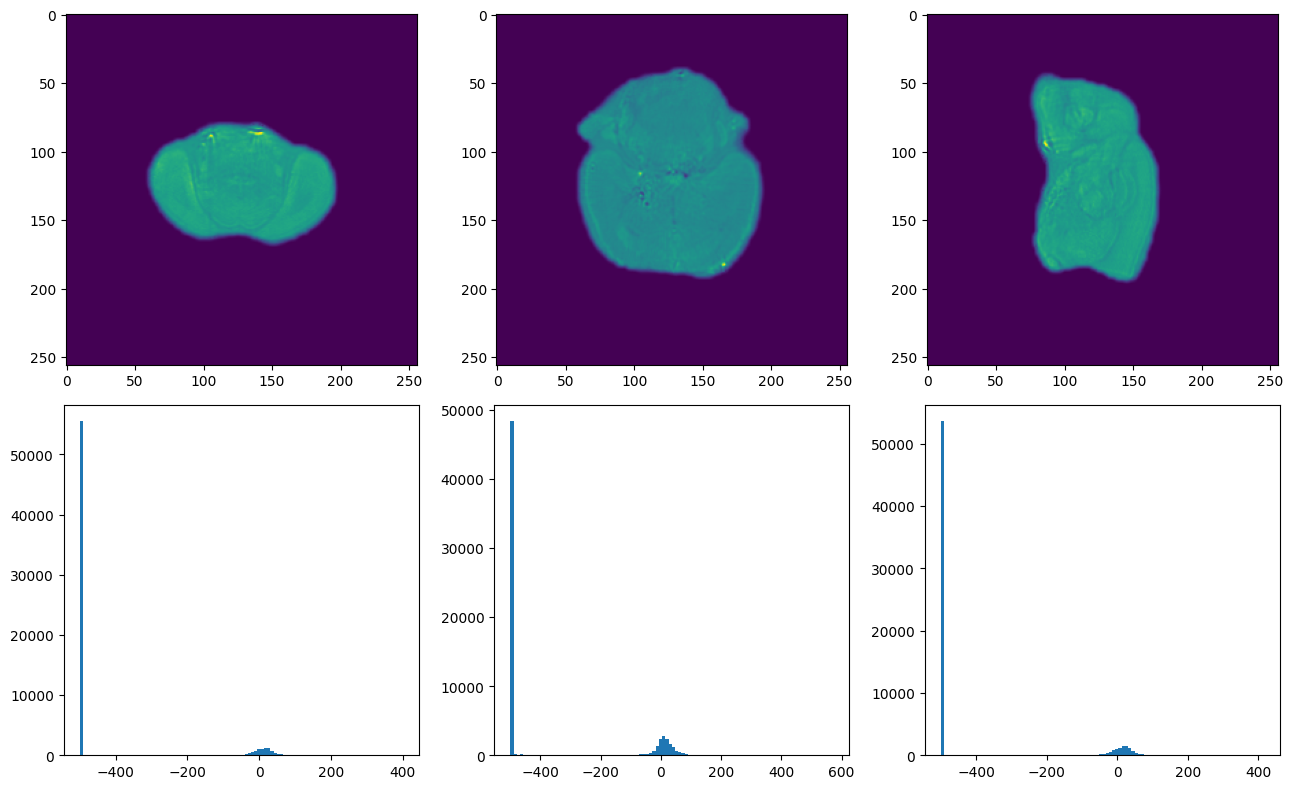

In [120]:
plt.figure(figsize=(13,8))
plt.subplot(2,3,1)
plt.imshow(brain3d[x_sec,:,:])

plt.subplot(2,3,4)
plt.hist(brain3d[x_sec,:,:].ravel(), bins=100)

plt.subplot(2,3,2)
plt.imshow(brain3d[:,y_sec,:])

plt.subplot(2,3,5)
plt.hist(brain3d[:,y_sec,:].ravel(), bins=100)

plt.subplot(2,3,3)
plt.imshow(brain3d[:,:,z_sec])

plt.subplot(2,3,6)
plt.hist(brain3d[:,:,z_sec].ravel(), bins=100)

plt.tight_layout()

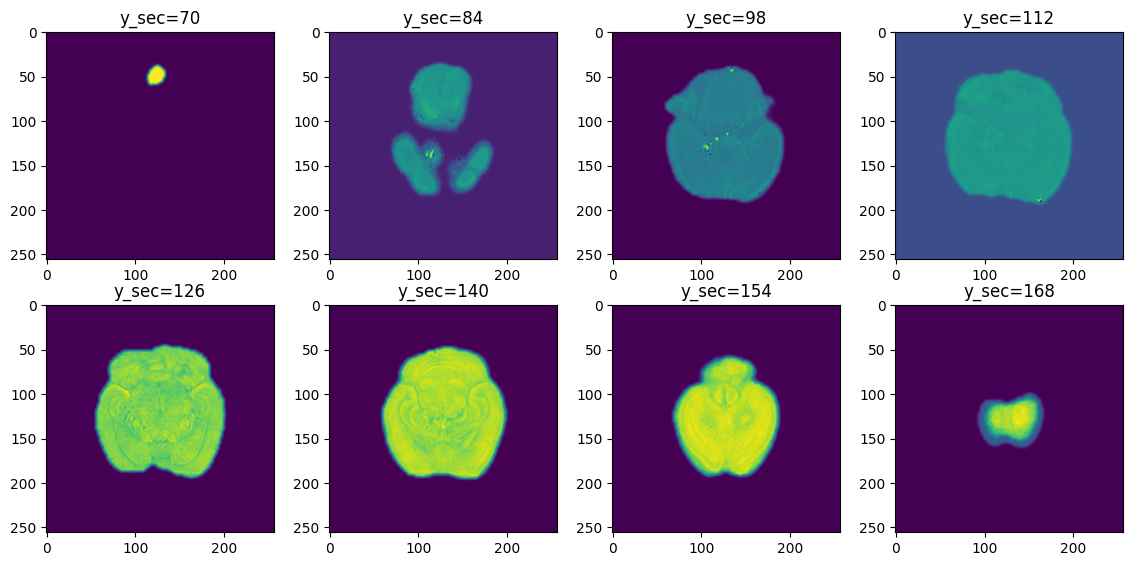

In [130]:
plt.figure(figsize=(14,7))
for i in range(8):
    plt.subplot(2,4,i+1)
    y_sec = i * 14 + 70
    plt.imshow(brain3d[:,y_sec,:])
    plt.title(f'y_sec={y_sec}')

Text(0.5, 1.0, 'Histogram')

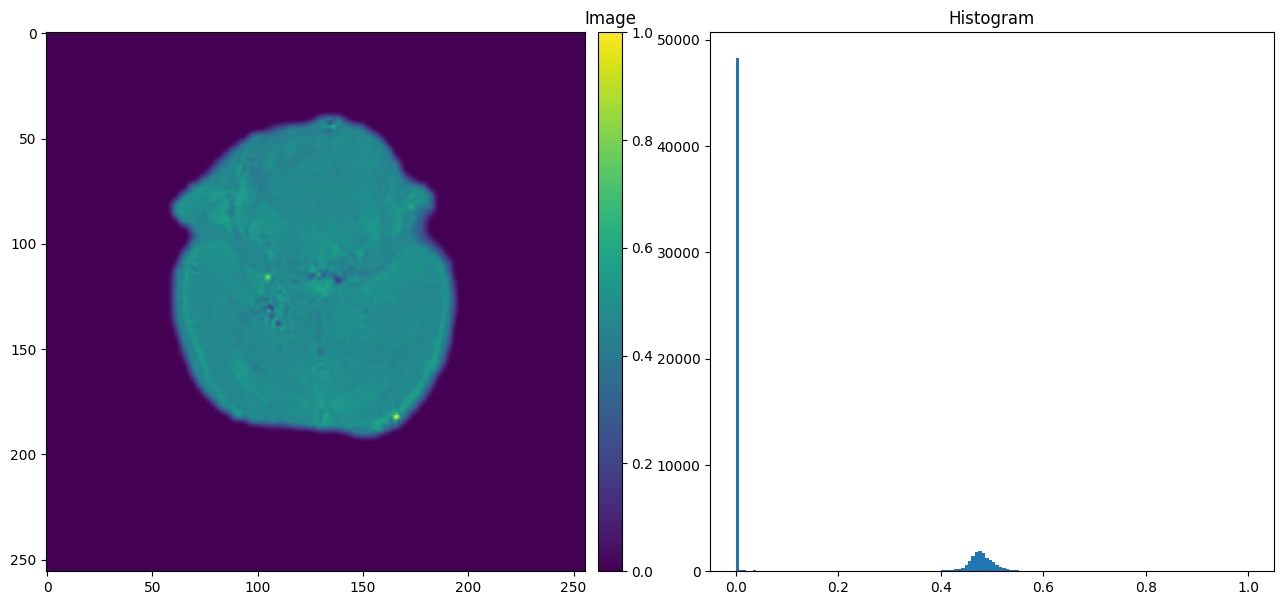

In [135]:
section = brain3d[:,100,:]
section = (section - section.min()) / (section.max() - section.min())

fig = plt.figure(figsize=(16,7))
ax1 = plt.subplot(1,2,1)
plt.imshow(section)
cax = fig.add_axes([ax1.get_position().x1+0.008, ax1.get_position().y0, 0.015, ax1.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.title('Image', fontsize=12)

ax2 = plt.subplot(1,2,2)
plt.hist(section.ravel(), bins=150)
plt.title('Histogram', fontsize=12)